<a href="https://colab.research.google.com/github/epetrashko/CV_PROJECT/blob/main/CV_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Downloads

In [1]:
!pip install timm -q

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import torch
from PIL import Image
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset

import torch.nn as nn
import torch.optim as optim

import gc
import os
from typing import Optional, List, Callable
from time import time
from tqdm.notebook import tqdm

     |████████████████████████████████| 549 kB 22.7 MB/s 
     |████████████████████████████████| 182 kB 66.4 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ICV/Project

# link to shared google drive https://drive.google.com/drive/folders/16KqOlY0Hnnk4xDJMn3H_NG7aR-TYcE03?usp=share_link

Mounted at /content/drive
/content/drive/MyDrive/ICV/Project


#### Extract nutrition5k dataset

In [ ]:
# !tar -xvf /content/drive/MyDrive/ICV/Project/train-v0.4.tar.gz -C dataset
# !unzip test_images-v0.4.tar.gz -d test
# !unzip val-v0.4.tar.gz -d .

#### Extract Yandex dataset

In [ ]:
# !unzip resized_imgs.zip

### Helper functions

In [25]:
# extracts `limit` filenames from `path` directory with skipping first `skip` files
def get_filenames(path: str, limit: Optional[int]=None, skip: Optional[int]=None) -> List[str]:
  filenames = []
  for index, filename in enumerate(os.listdir(path)):
    if skip != None and index < skip:
      continue
    f = os.path.join(path, filename)
    if os.path.isfile(f):
      filenames.append(f)
    if len(filenames) == limit:
      break
  return filenames

## Preprocessing

In [4]:
model = timm.create_model('inception_v3', pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [5]:
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

In [6]:
# Here we go through all rgb images in our subfolders `realsense_overhead/*`
# Extract filename and then we try to found rows in csv where id == `image_filename`
# we save this rows in our dictionary

def extract_useful_info_from_nutrition5k():
  # Extract csv files from Nutrition5k dataset 
  # We take 6 first columns image_id, calories, mass, fats, carbs, prots
  experiment1 = pd.read_csv('metadata/dish_metadata_cafe1.csv', usecols=range(6), header=None)
  experiment2 = pd.read_csv('metadata/dish_metadata_cafe1.csv', usecols=range(6), header=None)
  folder = "realsense_overhead"
  subfolders = [f.path for f in os.scandir(folder) if f.is_dir()]

  dishes = {}
  for subfolder in subfolders:
    if "rgb.png" in os.listdir(subfolder):
      id = subfolder[subfolder.index("/") + 1:]
      ser = experiment1.loc[experiment1[0] == id].values.flatten()
      if len(ser) == 0:
        ser = experiment2.loc[experiment2[0] == id].values.flatten()
        if len(ser) == 0:
          continue
        
      dishes[id] = ser
  
  # Save dictionary obtained above in csv file with only useful for us info
  df = pd.DataFrame.from_dict(dishes, orient='index', columns=['image', 'cal', 'mass', 'fat', 'carb', 'prot']).reset_index(drop=True)
  df.to_csv("preprocessing.csv")
  del dishes
  gc.collect()

In [7]:
# Here we go through our Nutrition5k preprocessed data
# On each step we 
# 1) Open image with PIL
# 2) Apply some custom transformations (if needed)
# 3) Apply necessary transformation to suit model input
# 4) Write tensor data to dictionary
# Save dictionary in npz format, since it takes less space and it's more efficient
# than openning image each timae and transforming it
def archive_nutririon5k_image_info(dataset_path: str, npz_filename: str, image_name: str = "rgb.png", fn: Optional[Callable] = None):
  preprocessed_data = pd.read_csv('preprocessing.csv').to_numpy()
  saved_data = {}
  for data in tqdm(preprocessed_data):
    img = Image.open(f"{dataset_path}/{data[1]}/{image_name}").convert("RGB")
    if fn is not None:
      img = fn(img)
    saved_data[data[1]] = transform(img).unsqueeze(0)
  np.savez_compressed(npz_filename, **saved_data)
  del saved_data
  gc.collect()
    

# archive_nutririon5k_image_info(
#     dataset_path=folder,
#     npz_filename="processed_rgb_images"
# )

In [8]:
# Here we go through Yandex extracted images
# On each iteration we do:
# 1) Extract `batch` image filenames from our `path` with skipping `(iteration - 1) * batch` images
# 2) Find all rows where extracted filenames(Step#2) contains concreate filename
# 3) Open image with PIL
# 4) Apply some custom transformations (if needed)
# 5) Apply necessary transformation to suit model input
# 6) Write tensor data to dictionary
# 7) Save dictionary in npz format in `path_prefix_to_saved_npz_{iteration}` location
# 8) Delete dictionary and activate GC
def archive_yandex_image_info(path: str, path_prefix_to_saved_npz, iterations_limit: int, iterations_skip: int = 0, batch: int = 1000, fn: Optional[Callable] = None):
  # Import csv with extracted Yandex images
  url="https://raw.githubusercontent.com/gfx73/image2calories_dataset_collection/master/generated_datasets/dataset_with_paths.csv"
  yandex_table = pd.read_csv(url)

  for iteration in range(iterations_skip, iterations_skip + iterations_limit):
    selection = yandex_table.iloc[iteration * batch: (iteration + 1) * batch, :]
    processed_images = {}
    for _, data in enumerate(tqdm(selection.iterrows())):
      img_path = data[1]["filename"]
      img = Image.open(f"{path}/{img_path}").convert("RGB")
      if fn is not None:
        img = fn(img)
      img = transform(img).unsqueeze(0)
      processed_images[str(data[1]["id_"])] = img
    np.savez_compressed(f"{path_prefix_to_saved_npz}_{iteration + 1}", **processed_images)
    del processed_images
    gc.collect()

# archive_yandex_image_info(
#     path="resized_imgs",
#     path_prefix_to_saved_npz="preprocessed_yandex_images_new",
#     iterations_skip=3,
#     iterations_limit=3,
# )

### Nutrition5k DataLoaders

In [9]:
preprocessed_data = pd.read_csv('preprocessing.csv').to_numpy()
preprocessed_images = np.load("preprocessed_cropped_rgb_images.npz")

# divide nutrition5k preprocessed data to train, test and val
np.random.shuffle(preprocessed_data)
train_part = int(preprocessed_data.shape[0] * 0.8) 
test_val_part = int(preprocessed_data.shape[0] * 0.1)
train, val, test = preprocessed_data[:train_part,:], preprocessed_data[train_part: train_part + test_val_part,:], preprocessed_data[train_part + test_val_part:, :]

def get_dish_info(batch):
  img_tensors = []
  cals = []
  masses = []
  fats = []
  carbs = []
  prots = []
  for dish_info in batch:
    img_tensor = torch.tensor(preprocessed_images[dish_info[1]])
    img_tensors.append(img_tensor)
    cals.append(torch.tensor([dish_info[2]]).unsqueeze(0))
    masses.append(torch.tensor([dish_info[3]]).unsqueeze(0))
    fats.append(torch.tensor([dish_info[4]]).unsqueeze(0))
    carbs.append(torch.tensor([dish_info[5]]).unsqueeze(0))
    prots.append(torch.tensor([dish_info[6]]).unsqueeze(0))
  return torch.cat(img_tensors), torch.cat(cals), torch.cat(masses), torch.cat(fats), torch.cat(carbs), torch.cat(prots)

In [10]:
train_loader = DataLoader(train, batch_size = 32, drop_last=True, collate_fn=get_dish_info)
val_loader = DataLoader(val, batch_size = 32, drop_last=True, collate_fn=get_dish_info)
test_loader = DataLoader(test, batch_size = 32, drop_last=True, collate_fn=get_dish_info)

### Yandex DataLoaders

In [11]:
url="https://raw.githubusercontent.com/gfx73/image2calories_dataset_collection/master/generated_datasets/dataset_with_paths.csv"
yandex_table = pd.read_csv(url)
preprocessed_yandex_images = np.load("preprocessed_yandex_images_1.npz")

In [12]:
# This is manually collected dataset. We parsed usefual information from "Яндекс.Еда"
# After preprocessing ~6000 preprocessed images were saved in .npz files
class YandexSmallDataset(Dataset):
    def __init__(self):
        self.images1 = self.load_images(path="preprocessed_yandex_images_new_1.npz")
        self.images2 = self.load_images(path="preprocessed_yandex_images_new_2.npz")
        self.border_2_3 = len(self.images1) + len(self.images2)
        self.images3 = self.load_images(path="preprocessed_yandex_images_new_3.npz")
        self.border_3_4 = self.border_2_3 + len(self.images3)
        self.images4 = self.load_images(path="preprocessed_yandex_images_new_4.npz")
        self.border_4_5 = self.border_3_4 + len(self.images4)
        self.images5 = self.load_images(path="preprocessed_yandex_images_new_5.npz")
        self.border_5_6 = self.border_4_5 + len(self.images5)
        self.images6 = self.load_images(path="preprocessed_yandex_images_new_6.npz")
        self.index_to_image_key = {}
        self.__populate_index_dict()

    # Here we create intermidiate dictionary which will be our map
    # From model index to key in .npz value, since 
    # npz has key-value structure
    def __populate_index_dict(self):
      index = 0
      for keys_set in [self.images1.keys(), self.images2.keys(), self.images3.keys(), self.images4.keys(), self.images5.keys(), self.images6.keys()]:
        for key in keys_set:
          self.index_to_image_key[str(index)] = key
          index += 1

    # Load .npz file from path
    def load_images(self, path: str):
      return np.load(path)

    def __len__(self):
        return self.border_5_6 + len(self.images6)

    # Here using out intermidiate mapper we get key from our index
    def __index_to_key(self, index: int):
      return self.index_to_image_key[str(index)]

    # Current function determines where requested index is located
    # based on borders between files (Example: border_3_4 = border_2_3 + len(images3)
    def get_by_index(self, idx):
        key = self.__index_to_key(idx)
        if idx < len(self.images1):
          return self.images1[key], key
        elif len(self.images1) <= idx < self.border_2_3:
          return self.images2[key], key
        elif self.border_2_3 <= idx < self.border_3_4:
          return self.images3[key], key
        elif self.border_3_4 <= idx < self.border_4_5:
          return self.images4[key], key
        elif self.border_4_5 <= idx < self.border_5_6:
          return self.images5[key], key
        else:
          return self.images6[key], key

    def __getitem__(self, idx):
        return self.get_by_index(idx)

In [13]:
yandex_table

,Unnamed: 0,id_,name,description,price,picture_uri,public_id,weight_value,weight_unit,calories_value,calories_unit,carbohydrates_value,carbohydrates_unit,fats_value,fats_unit,proteins_value,proteins_unit,category_name,filename
0,0,520854818,Сэндвич с авокадо и лососем,"Хлеб, лосось, авокадо.<br>На 100 граммов: К&th...",290,/images/3531870/d8a02262b96401072b1b2a746d5b60...,f2570905-ab29-4b9c-ad9b-4e92c1138ea4,170.0,g,685.0,ккал,42.0,г,20.0,г,13.0,г,сэндвичи & хот-доги,_images_3531870_d8a02262b96401072b1b2a746d5b60...
1,1,520854823,Сэндвич с Куриным филе и Ананасом,"Сэндвичный хлеб, куриное филе, ананас.<br>На 1...",290,/images/3436037/e37d19f0ff2a7bfd47529ab3f3c56b...,4a4e9a41-9989-48d8-a267-2a96bac08a5f,170.0,g,712.0,ккал,52.0,г,15.0,г,24.0,г,сэндвичи & хот-доги,_images_3436037_e37d19f0ff2a7bfd47529ab3f3c56b...
2,2,520854828,Сэндвич с Ростбифом,"Сэндвичный хлеб, ростбиф, сыр.<br>На 100 грамм...",290,/images/2394388/9d195a0a3a6f17077d784d9970a5c5...,3fbdddab-0ba1-4477-a3c4-3280f1749144,170.0,g,672.0,ккал,41.0,г,16.0,г,23.0,г,сэндвичи & хот-доги,_images_2394388_9d195a0a3a6f17077d784d9970a5c5...
3,3,519308053,Омлет с грибами и сыром,"Омлет, грибы шампиньоны, сыр, листья салата, т...",190,/images/3595156/73e2a19cb8207765841ce90e529abc...,f620aa4a-49cc-447b-9488-8ff6145342b6,145.0,g,506.0,ккал,4.0,г,28.0,г,21.0,г,завтрак,_images_3595156_73e2a19cb8207765841ce90e529abc...
4,4,519343468,Драник с яйцом пашот и помидором конкассе,"Картофель, лук репчатый, яйцо, помидоры, хлеб ...",190,/images/3569651/29c1313d69d05a36f1ae353161a684...,7a3668b9-314b-4987-b6a7-23a30a7bae97,250.0,g,720.0,ккал,26.0,г,18.0,г,5.0,г,завтрак,_images_3569651_29c1313d69d05a36f1ae353161a684...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63647,63647,1188621899,Хинкали с сыром,"Сыр сулугуни, тесто.<br>На 100 граммов: К&thin...",210,/images/3521394/ec4c0c5449f44b029258df943d5e27...,360c76a9-9f5e-402e-bc65-aca2b58cd830,300.0,g,702.0,ккал,24.0,г,8.0,г,13.0,г,хинкали,_images_3521394_ec4c0c5449f44b029258df943d5e27...
63648,63648,1188621749,Лобио по-имеретински,"Фасоль, лук, специи, зелень.<br>На 100 граммов...",410,/images/3513074/b91e39fda60e4268bd00f5ab828122...,a74b2ab0-5fa7-4cf2-b9a2-e6f95e6f33ba,250.0,g,350.0,ккал,22.0,г,5.0,г,8.0,г,горячие блюда,_images_3513074_b91e39fda60e4268bd00f5ab828122...
63649,63649,1188621794,Чахохбили из курицы,"Курица, специи.<br>На 100 граммов: К&thinsp;59...",390,/images/3439767/a60f8294216c4c4592a7889ce32a72...,9e25bf3d-710f-4124-9b3b-f7c24ee2777d,300.0,g,1785.0,ккал,50.0,г,38.0,г,50.0,г,горячие блюда,_images_3439767_a60f8294216c4c4592a7889ce32a72...
63650,63650,1188621904,Хачапури по-имеретински,"Сыр сулугуни, имеретинский сыр. Начинка только...",470,/images/3436037/bbce7eaabe3946b0b8eb75b4b55a3b...,ebc2bd5b-5d87-47c1-a01d-5e1b7234623a,450.0,g,2655.0,ккал,76.0,г,20.0,г,27.0,г,выпечка,_images_3436037_bbce7eaabe3946b0b8eb75b4b55a3b...


In [14]:
# Function which map dataset batch to model appropriate input
# In our case for our model we need to have following input
# For preprocessed images: (BATCH_SIZE, 3, 299, 299), For numeric info: (BATCH_SIZE, 1)
def get_yandex_dish_info(batch):
  img_tensors = []
  cals = []
  masses = []
  fats = []
  carbs = []
  prots = []
  for image_key in batch:
    key = image_key[1]
    row = yandex_table.loc[yandex_table['id_'] == int(key)]
    img_tensors.append(torch.tensor(image_key[0]))

    calls_value = float(row['calories_value'])
    mass_value = float(row['weight_value'])
    fats_value = float(row['fats_value'])
    carbs_value = float(row['carbohydrates_value'])
    prots_value = float(row['proteins_value'])

    cals.append(torch.tensor([calls_value]).unsqueeze(0))
    masses.append(torch.tensor([mass_value]).unsqueeze(0))
    fats.append(torch.tensor([fats_value]).unsqueeze(0))
    carbs.append(torch.tensor([carbs_value]).unsqueeze(0))
    prots.append(torch.tensor([prots_value]).unsqueeze(0))

  return torch.cat(img_tensors), torch.cat(cals), torch.cat(masses), torch.cat(fats), torch.cat(carbs), torch.cat(prots)

# divide yandex dataset in train, val and test (0.8, 0.1, 0.1)
yandex_dataset = YandexSmallDataset()
yandex_train_size = int(0.8 * len(yandex_dataset))
yandex_val_and_test_size = len(yandex_dataset) - yandex_train_size

yandex_test_size = int(0.5 * yandex_val_and_test_size)

yandex_train_dataset, yandex_val_dataset = torch.utils.data.random_split(yandex_dataset, [yandex_train_size, yandex_val_and_test_size])
yandex_val_dataset, yandex_test_dataset = torch.utils.data.random_split(yandex_val_dataset, [yandex_val_and_test_size - yandex_test_size, yandex_test_size])

train_yandex_loader = DataLoader(yandex_train_dataset, batch_size = 32, drop_last=True, collate_fn=get_yandex_dish_info)
val_yandex_loader = DataLoader(yandex_val_dataset, batch_size = 32, drop_last=True, collate_fn=get_yandex_dish_info)
test_yandex_loader = DataLoader(yandex_test_dataset, batch_size = 32, drop_last=True, collate_fn=get_yandex_dish_info)

## Model

In [15]:
# creating device to use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# our network for predicting calories and macronutrients
class MyNetwork(nn.Module):
  def __init__(self):
    super(MyNetwork, self).__init__()

    # initialize base Inception V3 model and freeze weights
    self.inception_model = timm.create_model('inception_v3', pretrained=True)
    for p in self.inception_model.parameters():
      p.requires_grad = True
    
    # put model on device
    self.inception_model = self.inception_model.to(device)

    # pooling layer for feature map
    self.pooling = nn.AvgPool2d(3, stride=2)
    self.act1 = nn.LeakyReLU(0.2)

    # same FC layers and activations for regression tasks
    self.fc1 = nn.Linear(3*3*2048, 4096)
    self.act2 = nn.LeakyReLU(0.2)
    self.fc2 = nn.Linear(4096, 4096)
    self.act3 = nn.LeakyReLU(0.2)
    self.fc2 = nn.Linear(4096, 4096)
    self.act4 = nn.LeakyReLU(0.2)

    # FC layers and activations for each regression task
    self.cal_fc3 = nn.Linear(4096, 4096)
    self.cal_act3 = nn.LeakyReLU(0.2)
    self.fat_fc3 = nn.Linear(4096, 4096)
    self.fat_act3 = nn.LeakyReLU(0.2)
    self.carb_fc3 = nn.Linear(4096, 4096)
    self.carb_act3 = nn.LeakyReLU(0.2)
    self.prot_fc3 = nn.Linear(4096, 4096)
    self.prot_act3 = nn.LeakyReLU(0.2)

    self.cal_fc4 = nn.Linear(4096, 1)
    self.fat_fc4 = nn.Linear(4096, 1)
    self.carb_fc4 = nn.Linear(4096, 1)
    self.prot_fc4 = nn.Linear(4096, 1)

  def forward(self, x):

    # get feature map from Inception V3 model
    feature_output = self.inception_model.forward_features(x)

    out = self.pooling(feature_output)

    out = out.view(-1, 3*3*2048)
    out = self.act1(out)

    # apply FC layers and activation one by one
    out = self.fc1(out)
    out = self.act2(out)
    out = self.fc2(out)
    out = self.act3(out)

    cal_out = self.cal_fc3(out)
    cal_out = self.cal_act3(cal_out)
    fat_out = self.fat_fc3(out)
    fat_out = self.fat_act3(fat_out)
    carb_out = self.carb_fc3(out)
    carb_out = self.carb_act3(carb_out)
    prot_out = self.prot_fc3(out)
    prot_out = self.prot_act3(prot_out)


    cal_out = self.cal_fc4(cal_out)
    fat_out = self.fat_fc4(fat_out)
    carb_out = self.carb_fc4(carb_out)
    prot_out = self.prot_fc4(prot_out)

    return cal_out, fat_out, carb_out, prot_out

In [17]:
# create model for predicting calories and macronutrients
net = MyNetwork()

In [ ]:
net = net.to(device)

In [18]:
# create mean abcolute error (MAE) loss function
loss_function = nn.L1Loss()

# create RMSprop optimizer
# optimizer = optim.RMSprop(net.parameters(), lr=1e-4, eps=1, weight_decay=0.9, momentum=0.9)
optimizer = optim.RMSprop(net.parameters(), lr=1e-4)

In [19]:
# function to evalute our model
def eval(val_loader):
  model.eval()

  cal_running_loss = 0
  fat_running_loss = 0
  carb_running_loss = 0
  prot_running_loss = 0

  # iterate through all batches
  for iteration, (imgs, cals, masses, fats, carbs, prots) in tqdm(enumerate(val_loader), total=len(val_loader)):
    with torch.no_grad():
      # put tensors on device
      imgs, cals, masses, fats, carbs, prots = imgs.to(device), cals.to(device), masses.to(device), fats.to(device), carbs.to(device), prots.to(device)

      # get predicted values
      cal_pred, fat_pred, carb_pred, prot_pred = net(imgs)

      # calculate MAE loss for each regression task
      # multiply each predicted result by true mass to get more understandable result
      cal_loss = loss_function(cal_pred * masses, cals)
      fat_loss = loss_function(fat_pred * masses, fats)
      carb_loss = loss_function(carb_pred * masses, carbs)
      prot_loss = loss_function(prot_pred * masses, prots)

      # calculate running loss for each regression task
      cal_running_loss += cal_loss.item()
      fat_running_loss += fat_loss.item()
      carb_running_loss += carb_loss.item()
      prot_running_loss += prot_loss.item()

  # return validation loss for each regression task
  return cal_running_loss / len(val_loader), fat_running_loss / len(val_loader), carb_running_loss / len(val_loader), prot_running_loss / len(val_loader)

In [20]:
# function to train our model
def train(epoch, net, loss_function, optimizer, train_loader, val_loader):
  net = net.to(device)
  net.train()

  running_loss = 0

  # iterate through all batches
  for iteration, (imgs, cals, masses, fats, carbs, prots) in tqdm(enumerate(train_loader), total=len(train_loader)):
    optimizer.zero_grad()
    # put tensors on device
    imgs, cals, masses, fats, carbs, prots = imgs.to(device), cals.to(device), masses.to(device), fats.to(device), carbs.to(device), prots.to(device)

    # get predicted values
    cal_pred, fat_pred, carb_pred, prot_pred = net(imgs)

    # calculate weighted combination of MAE losses for each regression task
    loss = (loss_function(cal_pred, cals / masses) + 
            loss_function(fat_pred, fats / masses) + 
            loss_function(carb_pred, carbs / masses) + 
            loss_function(prot_pred, prots / masses)) / 4
    running_loss += loss.item()

    loss.backward()
    optimizer.step()

    # to print statistics
    if iteration % 10 == 0:
      _loss = running_loss / (iteration + 1)
      print("epoch: {}\titeration: {}\tloss: {}\tthis iteration loss: {}".format(epoch, iteration, _loss, loss))
  
  # to print statistics
  print("epoch: {}\ttrain loss: {}".format(epoch, running_loss / len(train_loader)))

  # to save our model weights
  if epoch % 10 == 0:
    torch.save(net, f'net{epoch}.pt')

  # test model on validation set
  cal_eval_loss, fat_eval_loss, carb_eval_loss, prot_eval_loss = eval(val_loader)
  print("epoch: {}\tcal_valid loss: {}\tfat_valid loss: {}\tcarb_valid loss: {}\tprot_valid loss: {}".format(epoch, cal_eval_loss, fat_eval_loss, carb_eval_loss, prot_eval_loss))

In [23]:
# training model
for epoch in range(1, 41):
  # train(epoch, net, loss_function, optimizer, train_yandex_loader, val_yandex_loader)
  train(epoch, net, loss_function, optimizer, train_loader, val_loader)

  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 1	iteration: 0	loss: 0.37328097224235535	this iteration loss: 0.37328097224235535
epoch: 1	iteration: 10	loss: 0.29553521356799384	this iteration loss: 0.33580321073532104
epoch: 1	iteration: 20	loss: 0.2754029000089282	this iteration loss: 0.2289147973060608
epoch: 1	iteration: 30	loss: 0.3377325816019889	this iteration loss: 2.2619738578796387
epoch: 1	iteration: 40	loss: 0.31421131786049866	this iteration loss: 0.18939480185508728
epoch: 1	iteration: 50	loss: 0.29635101103899525	this iteration loss: 0.13744637370109558
epoch: 1	iteration: 60	loss: 0.28177313592101705	this iteration loss: 0.21121245622634888
epoch: 1	iteration: 70	loss: 0.2719637444111663	this iteration loss: 0.19869372248649597
epoch: 1	iteration: 80	loss: 0.2606644506255786	this iteration loss: 0.2064608931541443
epoch: 1	train loss: 0.2606644506255786


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1	cal_valid loss: 85.1577163696289	fat_valid loss: 10.206951570510864	carb_valid loss: 10.73340048789978	prot_valid loss: 10.165556716918946


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 2	iteration: 0	loss: 0.22882463037967682	this iteration loss: 0.22882463037967682
epoch: 2	iteration: 10	loss: 0.17677140371365982	this iteration loss: 0.19104404747486115
epoch: 2	iteration: 20	loss: 0.1775354210819517	this iteration loss: 0.19781993329524994
epoch: 2	iteration: 30	loss: 0.18620719304007868	this iteration loss: 0.18450219929218292
epoch: 2	iteration: 40	loss: 0.18428985229352626	this iteration loss: 0.14885151386260986
epoch: 2	iteration: 50	loss: 0.1842546018899656	this iteration loss: 0.12041233479976654
epoch: 2	iteration: 60	loss: 0.18084485804448364	this iteration loss: 0.18604940176010132
epoch: 2	iteration: 70	loss: 0.18171636267027386	this iteration loss: 0.23881345987319946
epoch: 2	iteration: 80	loss: 0.1771542102466395	this iteration loss: 0.13410258293151855
epoch: 2	train loss: 0.1771542102466395


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 2	cal_valid loss: 86.40142517089843	fat_valid loss: 9.704852771759032	carb_valid loss: 9.808423185348511	prot_valid loss: 10.095224857330322


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 3	iteration: 0	loss: 0.19753186404705048	this iteration loss: 0.19753186404705048
epoch: 3	iteration: 10	loss: 0.139801257035949	this iteration loss: 0.16746467351913452
epoch: 3	iteration: 20	loss: 0.1454973965883255	this iteration loss: 0.16303661465644836
epoch: 3	iteration: 30	loss: 0.1579412435812335	this iteration loss: 0.11850398033857346
epoch: 3	iteration: 40	loss: 0.15320353627931782	this iteration loss: 0.12803703546524048
epoch: 3	iteration: 50	loss: 0.15534507074192458	this iteration loss: 0.14534515142440796
epoch: 3	iteration: 60	loss: 0.15184819295269544	this iteration loss: 0.12904101610183716
epoch: 3	iteration: 70	loss: 0.15347178122946914	this iteration loss: 0.25551703572273254
epoch: 3	iteration: 80	loss: 0.14992016075569906	this iteration loss: 0.13121891021728516
epoch: 3	train loss: 0.14992016075569906


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 3	cal_valid loss: 66.98796310424805	fat_valid loss: 5.753315091133118	carb_valid loss: 9.080235242843628	prot_valid loss: 8.453094244003296


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 4	iteration: 0	loss: 0.13438081741333008	this iteration loss: 0.13438081741333008
epoch: 4	iteration: 10	loss: 0.11985438181595369	this iteration loss: 0.119104765355587
epoch: 4	iteration: 20	loss: 0.12211882571379344	this iteration loss: 0.13103201985359192
epoch: 4	iteration: 30	loss: 0.12610444306365906	this iteration loss: 0.145793154835701
epoch: 4	iteration: 40	loss: 0.12460451518617026	this iteration loss: 0.10273946076631546
epoch: 4	iteration: 50	loss: 0.12709024636184468	this iteration loss: 0.08712699264287949
epoch: 4	iteration: 60	loss: 0.12761163564979053	this iteration loss: 0.18657048046588898
epoch: 4	iteration: 70	loss: 0.12852485068667102	this iteration loss: 0.1818993091583252
epoch: 4	iteration: 80	loss: 0.12549787318264996	this iteration loss: 0.10498207062482834
epoch: 4	train loss: 0.12549787318264996


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 4	cal_valid loss: 66.85929374694824	fat_valid loss: 5.7983204364776615	carb_valid loss: 8.356584358215333	prot_valid loss: 8.465279626846314


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 5	iteration: 0	loss: 0.10974151641130447	this iteration loss: 0.10974151641130447
epoch: 5	iteration: 10	loss: 0.11107340929183093	this iteration loss: 0.1407081037759781
epoch: 5	iteration: 20	loss: 0.10675826633260363	this iteration loss: 0.10421533137559891
epoch: 5	iteration: 30	loss: 0.11334929495088515	this iteration loss: 0.08715049922466278
epoch: 5	iteration: 40	loss: 0.10946648168127711	this iteration loss: 0.09190363436937332
epoch: 5	iteration: 50	loss: 0.11230466441780913	this iteration loss: 0.09733936935663223
epoch: 5	iteration: 60	loss: 0.11269879939614749	this iteration loss: 0.11082427203655243
epoch: 5	iteration: 70	loss: 0.11351137618783494	this iteration loss: 0.10379448533058167
epoch: 5	iteration: 80	loss: 0.11344343318063536	this iteration loss: 0.18566736578941345
epoch: 5	train loss: 0.11344343318063536


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 5	cal_valid loss: 60.7958927154541	fat_valid loss: 6.231763315200806	carb_valid loss: 8.74510908126831	prot_valid loss: 8.0351713180542


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 6	iteration: 0	loss: 0.0735199823975563	this iteration loss: 0.0735199823975563
epoch: 6	iteration: 10	loss: 0.0907115638256073	this iteration loss: 0.12554925680160522
epoch: 6	iteration: 20	loss: 0.1001933209952854	this iteration loss: 0.09015437960624695
epoch: 6	iteration: 30	loss: 0.10729743059604399	this iteration loss: 0.0965069904923439
epoch: 6	iteration: 40	loss: 0.10926955393174799	this iteration loss: 0.07591614127159119
epoch: 6	iteration: 50	loss: 0.109541009600256	this iteration loss: 0.11416912078857422
epoch: 6	iteration: 60	loss: 0.10915750625436424	this iteration loss: 0.10192933678627014
epoch: 6	iteration: 70	loss: 0.11153085230731628	this iteration loss: 0.16231808066368103
epoch: 6	iteration: 80	loss: 0.1090114632230482	this iteration loss: 0.13096997141838074
epoch: 6	train loss: 0.1090114632230482


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 6	cal_valid loss: 63.484466552734375	fat_valid loss: 7.184782838821411	carb_valid loss: 7.9032354831695555	prot_valid loss: 8.355791282653808


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 7	iteration: 0	loss: 0.08260062336921692	this iteration loss: 0.08260062336921692
epoch: 7	iteration: 10	loss: 0.08300415087829936	this iteration loss: 0.1067037284374237
epoch: 7	iteration: 20	loss: 0.08654275181747619	this iteration loss: 0.09183001518249512
epoch: 7	iteration: 30	loss: 0.09389015888014147	this iteration loss: 0.1315910816192627
epoch: 7	iteration: 40	loss: 0.09764858544236277	this iteration loss: 0.11292774975299835
epoch: 7	iteration: 50	loss: 0.09643932285846449	this iteration loss: 0.06211293861269951
epoch: 7	iteration: 60	loss: 0.09735326517800816	this iteration loss: 0.11135141551494598
epoch: 7	iteration: 70	loss: 0.09839059475442054	this iteration loss: 0.09560967236757278
epoch: 7	iteration: 80	loss: 0.09642533553235325	this iteration loss: 0.095451220870018
epoch: 7	train loss: 0.09642533553235325


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 7	cal_valid loss: 62.801636123657225	fat_valid loss: 6.102137231826783	carb_valid loss: 7.57474718093872	prot_valid loss: 8.651863050460815


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 8	iteration: 0	loss: 0.06485576927661896	this iteration loss: 0.06485576927661896
epoch: 8	iteration: 10	loss: 0.08729245310479944	this iteration loss: 0.10814826190471649
epoch: 8	iteration: 20	loss: 0.08991553102220808	this iteration loss: 0.08997495472431183
epoch: 8	iteration: 30	loss: 0.09260540143136055	this iteration loss: 0.08271373808383942
epoch: 8	iteration: 40	loss: 0.08988290934301005	this iteration loss: 0.05763433501124382
epoch: 8	iteration: 50	loss: 0.09147007339725308	this iteration loss: 0.10175147652626038
epoch: 8	iteration: 60	loss: 0.09068102389574051	this iteration loss: 0.0729026049375534
epoch: 8	iteration: 70	loss: 0.0916558132624962	this iteration loss: 0.11130158603191376
epoch: 8	iteration: 80	loss: 0.09065253798056531	this iteration loss: 0.09294048696756363
epoch: 8	train loss: 0.09065253798056531


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 8	cal_valid loss: 74.09689712524414	fat_valid loss: 6.759582757949829	carb_valid loss: 7.039679718017578	prot_valid loss: 9.199564361572266


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 9	iteration: 0	loss: 0.09696760773658752	this iteration loss: 0.09696760773658752
epoch: 9	iteration: 10	loss: 0.08967143161730333	this iteration loss: 0.11719745397567749
epoch: 9	iteration: 20	loss: 0.08742614321055867	this iteration loss: 0.09879656136035919
epoch: 9	iteration: 30	loss: 0.09458561950633602	this iteration loss: 0.08074556291103363
epoch: 9	iteration: 40	loss: 0.09342568322289281	this iteration loss: 0.0926702469587326
epoch: 9	iteration: 50	loss: 0.09287869338603581	this iteration loss: 0.07132376730442047
epoch: 9	iteration: 60	loss: 0.09266052669921859	this iteration loss: 0.07744906842708588
epoch: 9	iteration: 70	loss: 0.09608912557153634	this iteration loss: 0.09275313466787338
epoch: 9	iteration: 80	loss: 0.09404321502388259	this iteration loss: 0.09094945341348648
epoch: 9	train loss: 0.09404321502388259


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 9	cal_valid loss: 60.621247100830075	fat_valid loss: 5.654184103012085	carb_valid loss: 9.009294748306274	prot_valid loss: 8.084492778778076


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 10	iteration: 0	loss: 0.055609218776226044	this iteration loss: 0.055609218776226044
epoch: 10	iteration: 10	loss: 0.0867661058225415	this iteration loss: 0.09321704506874084
epoch: 10	iteration: 20	loss: 0.0854964346757957	this iteration loss: 0.08242461830377579
epoch: 10	iteration: 30	loss: 0.09121199228590535	this iteration loss: 0.07047265768051147
epoch: 10	iteration: 40	loss: 0.08921768479957813	this iteration loss: 0.05526982620358467
epoch: 10	iteration: 50	loss: 0.0887860367257221	this iteration loss: 0.05007863789796829
epoch: 10	iteration: 60	loss: 0.08842461965367442	this iteration loss: 0.0705023929476738
epoch: 10	iteration: 70	loss: 0.08942453106734115	this iteration loss: 0.0846826583147049
epoch: 10	iteration: 80	loss: 0.08792398718220217	this iteration loss: 0.08011633902788162
epoch: 10	train loss: 0.08792398718220217


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 10	cal_valid loss: 64.16752128601074	fat_valid loss: 6.677099943161011	carb_valid loss: 8.325665092468261	prot_valid loss: 8.15763087272644


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 11	iteration: 0	loss: 0.06489206105470657	this iteration loss: 0.06489206105470657
epoch: 11	iteration: 10	loss: 0.0827506198124452	this iteration loss: 0.09546422213315964
epoch: 11	iteration: 20	loss: 0.08267453224176452	this iteration loss: 0.06891325116157532
epoch: 11	iteration: 30	loss: 0.08387003514555193	this iteration loss: 0.11049148440361023
epoch: 11	iteration: 40	loss: 0.08420702660592591	this iteration loss: 0.06980714201927185
epoch: 11	iteration: 50	loss: 0.08312300227436364	this iteration loss: 0.070079006254673
epoch: 11	iteration: 60	loss: 0.08406059266846688	this iteration loss: 0.11643611639738083
epoch: 11	iteration: 70	loss: 0.08506840656340962	this iteration loss: 0.10101772844791412
epoch: 11	iteration: 80	loss: 0.08395132615610405	this iteration loss: 0.1353190541267395
epoch: 11	train loss: 0.08395132615610405


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 11	cal_valid loss: 56.66455574035645	fat_valid loss: 4.795196080207825	carb_valid loss: 6.777627420425415	prot_valid loss: 6.284493684768677


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 12	iteration: 0	loss: 0.05580790340900421	this iteration loss: 0.05580790340900421
epoch: 12	iteration: 10	loss: 0.07285760918801482	this iteration loss: 0.07470233738422394
epoch: 12	iteration: 20	loss: 0.07508027056852977	this iteration loss: 0.07212509214878082
epoch: 12	iteration: 30	loss: 0.07839562611714486	this iteration loss: 0.07629483193159103
epoch: 12	iteration: 40	loss: 0.07890258802146446	this iteration loss: 0.060840487480163574
epoch: 12	iteration: 50	loss: 0.07907000520065718	this iteration loss: 0.05931742116808891
epoch: 12	iteration: 60	loss: 0.07901931511329822	this iteration loss: 0.06973300129175186
epoch: 12	iteration: 70	loss: 0.07914799556765757	this iteration loss: 0.06968072056770325
epoch: 12	iteration: 80	loss: 0.07792218116882407	this iteration loss: 0.07479936629533768
epoch: 12	train loss: 0.07792218116882407


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 12	cal_valid loss: 59.77422103881836	fat_valid loss: 5.577990007400513	carb_valid loss: 7.639907741546631	prot_valid loss: 6.469739294052124


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 13	iteration: 0	loss: 0.06853944063186646	this iteration loss: 0.06853944063186646
epoch: 13	iteration: 10	loss: 0.07658451931043105	this iteration loss: 0.1632232964038849
epoch: 13	iteration: 20	loss: 0.07827115200814747	this iteration loss: 0.09358769655227661
epoch: 13	iteration: 30	loss: 0.08048482575724202	this iteration loss: 0.06052481383085251
epoch: 13	iteration: 40	loss: 0.08152066879883045	this iteration loss: 0.048656705766916275
epoch: 13	iteration: 50	loss: 0.08169708408269227	this iteration loss: 0.0857413187623024
epoch: 13	iteration: 60	loss: 0.08045125948112519	this iteration loss: 0.06090466305613518
epoch: 13	iteration: 70	loss: 0.0820659747425939	this iteration loss: 0.07604765146970749
epoch: 13	iteration: 80	loss: 0.08038666264878379	this iteration loss: 0.11715787649154663
epoch: 13	train loss: 0.08038666264878379


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 13	cal_valid loss: 52.48806533813477	fat_valid loss: 4.755398583412171	carb_valid loss: 7.599772024154663	prot_valid loss: 9.392663526535035


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 14	iteration: 0	loss: 0.0510864183306694	this iteration loss: 0.0510864183306694
epoch: 14	iteration: 10	loss: 0.06613346798853441	this iteration loss: 0.09124159812927246
epoch: 14	iteration: 20	loss: 0.06713491660498437	this iteration loss: 0.056458067148923874
epoch: 14	iteration: 30	loss: 0.07267426711417013	this iteration loss: 0.07257512211799622
epoch: 14	iteration: 40	loss: 0.07432192473149882	this iteration loss: 0.0750977173447609
epoch: 14	iteration: 50	loss: 0.0742085164814603	this iteration loss: 0.08282504230737686
epoch: 14	iteration: 60	loss: 0.07219777628779411	this iteration loss: 0.08259029686450958
epoch: 14	iteration: 70	loss: 0.07296092057941665	this iteration loss: 0.057406987994909286
epoch: 14	iteration: 80	loss: 0.07240473055913124	this iteration loss: 0.08591798692941666
epoch: 14	train loss: 0.07240473055913124


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 14	cal_valid loss: 52.56954498291016	fat_valid loss: 4.680809712409973	carb_valid loss: 6.979720163345337	prot_valid loss: 6.730436325073242


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 15	iteration: 0	loss: 0.054640524089336395	this iteration loss: 0.054640524089336395
epoch: 15	iteration: 10	loss: 0.07346005534583872	this iteration loss: 0.07802248746156693
epoch: 15	iteration: 20	loss: 0.07142440815057073	this iteration loss: 0.07160066813230515
epoch: 15	iteration: 30	loss: 0.06921446972316311	this iteration loss: 0.053391456604003906
epoch: 15	iteration: 40	loss: 0.06866359138270704	this iteration loss: 0.050908416509628296
epoch: 15	iteration: 50	loss: 0.06793651970870354	this iteration loss: 0.063807412981987
epoch: 15	iteration: 60	loss: 0.06795747547608907	this iteration loss: 0.10469048470258713
epoch: 15	iteration: 70	loss: 0.06827689738760531	this iteration loss: 0.05725231394171715
epoch: 15	iteration: 80	loss: 0.06692393289672004	this iteration loss: 0.07011550664901733
epoch: 15	train loss: 0.06692393289672004


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 15	cal_valid loss: 51.725838851928714	fat_valid loss: 4.570205211639404	carb_valid loss: 7.83080563545227	prot_valid loss: 7.938904190063477


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 16	iteration: 0	loss: 0.04086393862962723	this iteration loss: 0.04086393862962723
epoch: 16	iteration: 10	loss: 0.06975688243454153	this iteration loss: 0.10148903727531433
epoch: 16	iteration: 20	loss: 0.06631109366814296	this iteration loss: 0.0498783104121685
epoch: 16	iteration: 30	loss: 0.06632970441733638	this iteration loss: 0.08089737594127655
epoch: 16	iteration: 40	loss: 0.06923898772858991	this iteration loss: 0.06613630801439285
epoch: 16	iteration: 50	loss: 0.06688170719380472	this iteration loss: 0.04408920556306839
epoch: 16	iteration: 60	loss: 0.06575291109133939	this iteration loss: 0.05788130313158035
epoch: 16	iteration: 70	loss: 0.0661713315672438	this iteration loss: 0.07528982311487198
epoch: 16	iteration: 80	loss: 0.06462901936453065	this iteration loss: 0.07276561856269836
epoch: 16	train loss: 0.06462901936453065


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 16	cal_valid loss: 51.955420875549315	fat_valid loss: 4.673976469039917	carb_valid loss: 6.679062843322754	prot_valid loss: 6.17293918132782


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 17	iteration: 0	loss: 0.04800032824277878	this iteration loss: 0.04800032824277878
epoch: 17	iteration: 10	loss: 0.06327856196598573	this iteration loss: 0.0537295937538147
epoch: 17	iteration: 20	loss: 0.060568399549949734	this iteration loss: 0.0722714513540268
epoch: 17	iteration: 30	loss: 0.06297073885798454	this iteration loss: 0.057095881551504135
epoch: 17	iteration: 40	loss: 0.06234813563343955	this iteration loss: 0.04803076013922691
epoch: 17	iteration: 50	loss: 0.06334818863109046	this iteration loss: 0.06718660145998001
epoch: 17	iteration: 60	loss: 0.062468736814182316	this iteration loss: 0.04884806275367737
epoch: 17	iteration: 70	loss: 0.06301656402122806	this iteration loss: 0.0594370998442173
epoch: 17	iteration: 80	loss: 0.06232450180399565	this iteration loss: 0.061490632593631744
epoch: 17	train loss: 0.06232450180399565


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 17	cal_valid loss: 50.38169822692871	fat_valid loss: 4.352436304092407	carb_valid loss: 6.336346006393432	prot_valid loss: 6.6623450756073


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 18	iteration: 0	loss: 0.042501531541347504	this iteration loss: 0.042501531541347504
epoch: 18	iteration: 10	loss: 0.05659648843786933	this iteration loss: 0.08056329190731049
epoch: 18	iteration: 20	loss: 0.061643753378164204	this iteration loss: 0.06918957084417343
epoch: 18	iteration: 30	loss: 0.06656146974813554	this iteration loss: 0.099893718957901
epoch: 18	iteration: 40	loss: 0.064891624377995	this iteration loss: 0.05267920345067978
epoch: 18	iteration: 50	loss: 0.06421952986834097	this iteration loss: 0.05370368808507919
epoch: 18	iteration: 60	loss: 0.0621703529699904	this iteration loss: 0.057602137327194214
epoch: 18	iteration: 70	loss: 0.061730084599743426	this iteration loss: 0.04256177321076393
epoch: 18	iteration: 80	loss: 0.060862606322323834	this iteration loss: 0.06310957670211792
epoch: 18	train loss: 0.060862606322323834


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 18	cal_valid loss: 54.01299133300781	fat_valid loss: 4.601114964485168	carb_valid loss: 6.93164095878601	prot_valid loss: 6.435924482345581


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 19	iteration: 0	loss: 0.05522722750902176	this iteration loss: 0.05522722750902176
epoch: 19	iteration: 10	loss: 0.057397819378159264	this iteration loss: 0.05346398428082466
epoch: 19	iteration: 20	loss: 0.05443425050803593	this iteration loss: 0.04104986786842346
epoch: 19	iteration: 30	loss: 0.05793101604907743	this iteration loss: 0.06589704751968384
epoch: 19	iteration: 40	loss: 0.05636048952980739	this iteration loss: 0.04396591708064079
epoch: 19	iteration: 50	loss: 0.05572679061807838	this iteration loss: 0.04319896176457405
epoch: 19	iteration: 60	loss: 0.057050489499920705	this iteration loss: 0.06617352366447449
epoch: 19	iteration: 70	loss: 0.05702099571345558	this iteration loss: 0.05363364890217781
epoch: 19	iteration: 80	loss: 0.055873264731080445	this iteration loss: 0.05807352438569069
epoch: 19	train loss: 0.055873264731080445


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 19	cal_valid loss: 68.18231773376465	fat_valid loss: 5.991660928726196	carb_valid loss: 7.263794231414795	prot_valid loss: 5.61364221572876


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 20	iteration: 0	loss: 0.1077171117067337	this iteration loss: 0.1077171117067337
epoch: 20	iteration: 10	loss: 0.05381488901647655	this iteration loss: 0.05439901724457741
epoch: 20	iteration: 20	loss: 0.0536547645571686	this iteration loss: 0.059076257050037384
epoch: 20	iteration: 30	loss: 0.05589307760519366	this iteration loss: 0.046498242765665054
epoch: 20	iteration: 40	loss: 0.05730850140495998	this iteration loss: 0.08878858387470245
epoch: 20	iteration: 50	loss: 0.057939281285393475	this iteration loss: 0.06117403879761696
epoch: 20	iteration: 60	loss: 0.0561322669697101	this iteration loss: 0.050842467695474625
epoch: 20	iteration: 70	loss: 0.05548064004052693	this iteration loss: 0.09943252801895142
epoch: 20	iteration: 80	loss: 0.05761956628182052	this iteration loss: 0.10454428941011429
epoch: 20	train loss: 0.05761956628182052


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 20	cal_valid loss: 174.68612518310547	fat_valid loss: 24.77278118133545	carb_valid loss: 32.017849922180176	prot_valid loss: 39.091326522827146


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 21	iteration: 0	loss: 0.3906223475933075	this iteration loss: 0.3906223475933075
epoch: 21	iteration: 10	loss: 0.11248682507059792	this iteration loss: 0.0696229636669159
epoch: 21	iteration: 20	loss: 0.08387777262500354	this iteration loss: 0.054107483476400375
epoch: 21	iteration: 30	loss: 0.07439717698481775	this iteration loss: 0.06792699545621872
epoch: 21	iteration: 40	loss: 0.06833476873069275	this iteration loss: 0.03917636349797249
epoch: 21	iteration: 50	loss: 0.06611298148830731	this iteration loss: 0.04061649367213249
epoch: 21	iteration: 60	loss: 0.06351140257520754	this iteration loss: 0.06286749243736267
epoch: 21	iteration: 70	loss: 0.06249302211151996	this iteration loss: 0.047272104769945145
epoch: 21	iteration: 80	loss: 0.0602554856673067	this iteration loss: 0.0489298477768898
epoch: 21	train loss: 0.0602554856673067


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 21	cal_valid loss: 48.5168270111084	fat_valid loss: 4.228006720542908	carb_valid loss: 5.763292264938355	prot_valid loss: 5.588409280776977


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 22	iteration: 0	loss: 0.051893200725317	this iteration loss: 0.051893200725317
epoch: 22	iteration: 10	loss: 0.05468097109008919	this iteration loss: 0.04202333837747574
epoch: 22	iteration: 20	loss: 0.04873732441947574	this iteration loss: 0.034644756466150284
epoch: 22	iteration: 30	loss: 0.04732712646645884	this iteration loss: 0.04491863772273064
epoch: 22	iteration: 40	loss: 0.048740513441039295	this iteration loss: 0.05205368995666504
epoch: 22	iteration: 50	loss: 0.04711721516123005	this iteration loss: 0.03931864723563194
epoch: 22	iteration: 60	loss: 0.045927286117536124	this iteration loss: 0.03509928658604622
epoch: 22	iteration: 70	loss: 0.04612893215052678	this iteration loss: 0.03474297747015953
epoch: 22	iteration: 80	loss: 0.0466277225655906	this iteration loss: 0.052065737545490265
epoch: 22	train loss: 0.0466277225655906


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 22	cal_valid loss: 48.98379611968994	fat_valid loss: 4.526777887344361	carb_valid loss: 5.828979921340943	prot_valid loss: 5.355524325370789


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 23	iteration: 0	loss: 0.03154541552066803	this iteration loss: 0.03154541552066803
epoch: 23	iteration: 10	loss: 0.04906812039288608	this iteration loss: 0.07002326101064682
epoch: 23	iteration: 20	loss: 0.046159036546235994	this iteration loss: 0.045701611787080765
epoch: 23	iteration: 30	loss: 0.04484018929783375	this iteration loss: 0.03299069032073021
epoch: 23	iteration: 40	loss: 0.043789262951510706	this iteration loss: 0.03665585815906525
epoch: 23	iteration: 50	loss: 0.04398558321682846	this iteration loss: 0.032815493643283844
epoch: 23	iteration: 60	loss: 0.04368800767621056	this iteration loss: 0.04287584498524666
epoch: 23	iteration: 70	loss: 0.04475798085331917	this iteration loss: 0.037795424461364746
epoch: 23	iteration: 80	loss: 0.044839728968562906	this iteration loss: 0.04368666559457779
epoch: 23	train loss: 0.044839728968562906


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 23	cal_valid loss: 46.852889442443846	fat_valid loss: 4.38778293132782	carb_valid loss: 6.010083150863648	prot_valid loss: 6.212352061271668


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 24	iteration: 0	loss: 0.03180869668722153	this iteration loss: 0.03180869668722153
epoch: 24	iteration: 10	loss: 0.04075803336772052	this iteration loss: 0.035978369414806366
epoch: 24	iteration: 20	loss: 0.04109370584289233	this iteration loss: 0.03591517359018326
epoch: 24	iteration: 30	loss: 0.041879508043489146	this iteration loss: 0.04841883108019829
epoch: 24	iteration: 40	loss: 0.041311933590871534	this iteration loss: 0.024973783642053604
epoch: 24	iteration: 50	loss: 0.04157046550044827	this iteration loss: 0.04673927277326584
epoch: 24	iteration: 60	loss: 0.04158440088761634	this iteration loss: 0.03082011453807354
epoch: 24	iteration: 70	loss: 0.04256907638004968	this iteration loss: 0.06072329357266426
epoch: 24	iteration: 80	loss: 0.04283560453741639	this iteration loss: 0.04210193082690239
epoch: 24	train loss: 0.04283560453741639


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 24	cal_valid loss: 50.36147804260254	fat_valid loss: 4.387426638603211	carb_valid loss: 5.559647512435913	prot_valid loss: 6.642217326164245


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 25	iteration: 0	loss: 0.04308359697461128	this iteration loss: 0.04308359697461128
epoch: 25	iteration: 10	loss: 0.042334818027236244	this iteration loss: 0.04987566918134689
epoch: 25	iteration: 20	loss: 0.04404362344316074	this iteration loss: 0.037073176354169846
epoch: 25	iteration: 30	loss: 0.0514301638449392	this iteration loss: 0.03860324248671532
epoch: 25	iteration: 40	loss: 0.053318868413930985	this iteration loss: 0.049336064606904984
epoch: 25	iteration: 50	loss: 0.05328394925477458	this iteration loss: 0.07812488824129105
epoch: 25	iteration: 60	loss: 0.051542172788596546	this iteration loss: 0.03668665140867233
epoch: 25	iteration: 70	loss: 0.051141058370261124	this iteration loss: 0.05489293113350868
epoch: 25	iteration: 80	loss: 0.04943440452126073	this iteration loss: 0.041131600737571716
epoch: 25	train loss: 0.04943440452126073


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 25	cal_valid loss: 51.239811706542966	fat_valid loss: 4.426122784614563	carb_valid loss: 6.250419282913208	prot_valid loss: 6.010136318206787


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 26	iteration: 0	loss: 0.053098153322935104	this iteration loss: 0.053098153322935104
epoch: 26	iteration: 10	loss: 0.040978446772152725	this iteration loss: 0.055530741810798645
epoch: 26	iteration: 20	loss: 0.03845522978476116	this iteration loss: 0.031689029186964035
epoch: 26	iteration: 30	loss: 0.03802055108451074	this iteration loss: 0.04437800869345665
epoch: 26	iteration: 40	loss: 0.038172176880080524	this iteration loss: 0.030597105622291565
epoch: 26	iteration: 50	loss: 0.03862363140226579	this iteration loss: 0.03666691854596138
epoch: 26	iteration: 60	loss: 0.039787182645475275	this iteration loss: 0.03721511363983154
epoch: 26	iteration: 70	loss: 0.040543507391088446	this iteration loss: 0.038716498762369156
epoch: 26	iteration: 80	loss: 0.04109026047826549	this iteration loss: 0.03753683343529701
epoch: 26	train loss: 0.04109026047826549


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 26	cal_valid loss: 49.531816482543945	fat_valid loss: 4.152098631858825	carb_valid loss: 6.06390905380249	prot_valid loss: 5.185650062561035


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 27	iteration: 0	loss: 0.028473280370235443	this iteration loss: 0.028473280370235443
epoch: 27	iteration: 10	loss: 0.03757284598594362	this iteration loss: 0.05547439306974411
epoch: 27	iteration: 20	loss: 0.040264426331434934	this iteration loss: 0.03966642916202545
epoch: 27	iteration: 30	loss: 0.04170822238008822	this iteration loss: 0.029468420892953873
epoch: 27	iteration: 40	loss: 0.041267363808867405	this iteration loss: 0.03617950156331062
epoch: 27	iteration: 50	loss: 0.04175191872990599	this iteration loss: 0.03611932322382927
epoch: 27	iteration: 60	loss: 0.04172530449682572	this iteration loss: 0.031705308705568314
epoch: 27	iteration: 70	loss: 0.042026211992955545	this iteration loss: 0.03174079209566116
epoch: 27	iteration: 80	loss: 0.041842722000531206	this iteration loss: 0.05594774708151817
epoch: 27	train loss: 0.041842722000531206


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 27	cal_valid loss: 52.98751640319824	fat_valid loss: 4.2354248523712155	carb_valid loss: 6.082471895217895	prot_valid loss: 4.935916328430176


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 28	iteration: 0	loss: 0.03708676993846893	this iteration loss: 0.03708676993846893
epoch: 28	iteration: 10	loss: 0.03944490071047436	this iteration loss: 0.05739954113960266
epoch: 28	iteration: 20	loss: 0.04031044572946571	this iteration loss: 0.03682423382997513
epoch: 28	iteration: 30	loss: 0.04309227744177464	this iteration loss: 0.07267656922340393
epoch: 28	iteration: 40	loss: 0.04226937135908662	this iteration loss: 0.04521086439490318
epoch: 28	iteration: 50	loss: 0.04269862752042565	this iteration loss: 0.05286325141787529
epoch: 28	iteration: 60	loss: 0.042248849802818456	this iteration loss: 0.04441239312291145
epoch: 28	iteration: 70	loss: 0.042470195816016534	this iteration loss: 0.04648931697010994
epoch: 28	iteration: 80	loss: 0.04229631369220622	this iteration loss: 0.04771034047007561
epoch: 28	train loss: 0.04229631369220622


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 28	cal_valid loss: 47.058774375915526	fat_valid loss: 4.197777438163757	carb_valid loss: 5.479227733612061	prot_valid loss: 5.03806700706482


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 29	iteration: 0	loss: 0.02607038803398609	this iteration loss: 0.02607038803398609
epoch: 29	iteration: 10	loss: 0.03738787465474822	this iteration loss: 0.053905364125967026
epoch: 29	iteration: 20	loss: 0.04178252328364622	this iteration loss: 0.03073642961680889
epoch: 29	iteration: 30	loss: 0.042482247576117516	this iteration loss: 0.028613103553652763
epoch: 29	iteration: 40	loss: 0.04285357742593056	this iteration loss: 0.047417234629392624
epoch: 29	iteration: 50	loss: 0.043713808096214835	this iteration loss: 0.046606533229351044
epoch: 29	iteration: 60	loss: 0.042813631934953515	this iteration loss: 0.03580298647284508
epoch: 29	iteration: 70	loss: 0.04327868095690936	this iteration loss: 0.03353360295295715
epoch: 29	iteration: 80	loss: 0.04308503776512764	this iteration loss: 0.04060334712266922
epoch: 29	train loss: 0.04308503776512764


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 29	cal_valid loss: 64.07835159301757	fat_valid loss: 5.679115605354309	carb_valid loss: 6.658301305770874	prot_valid loss: 7.039165496826172


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 30	iteration: 0	loss: 0.057647254317998886	this iteration loss: 0.057647254317998886
epoch: 30	iteration: 10	loss: 0.04037930850278248	this iteration loss: 0.03572322428226471
epoch: 30	iteration: 20	loss: 0.03742138491499992	this iteration loss: 0.029882393777370453
epoch: 30	iteration: 30	loss: 0.03967362576194348	this iteration loss: 0.04051632061600685
epoch: 30	iteration: 40	loss: 0.04116325493811107	this iteration loss: 0.04005465656518936
epoch: 30	iteration: 50	loss: 0.042037799808324554	this iteration loss: 0.050108302384614944
epoch: 30	iteration: 60	loss: 0.04206130049023472	this iteration loss: 0.037930797785520554
epoch: 30	iteration: 70	loss: 0.04139250753001428	this iteration loss: 0.03230267018079758
epoch: 30	iteration: 80	loss: 0.040663513297468055	this iteration loss: 0.04916667193174362
epoch: 30	train loss: 0.040663513297468055


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 30	cal_valid loss: 48.07785301208496	fat_valid loss: 4.36674861907959	carb_valid loss: 5.295099925994873	prot_valid loss: 5.201329302787781


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 31	iteration: 0	loss: 0.04065784439444542	this iteration loss: 0.04065784439444542
epoch: 31	iteration: 10	loss: 0.039120087400078773	this iteration loss: 0.03283742442727089
epoch: 31	iteration: 20	loss: 0.040666281733484494	this iteration loss: 0.03301075100898743
epoch: 31	iteration: 30	loss: 0.0414421483874321	this iteration loss: 0.03428726643323898
epoch: 31	iteration: 40	loss: 0.039942107822110016	this iteration loss: 0.024483608081936836
epoch: 31	iteration: 50	loss: 0.0401663734559335	this iteration loss: 0.040359705686569214
epoch: 31	iteration: 60	loss: 0.03923083212776262	this iteration loss: 0.032840706408023834
epoch: 31	iteration: 70	loss: 0.0390635412711073	this iteration loss: 0.021986212581396103
epoch: 31	iteration: 80	loss: 0.03880501867352444	this iteration loss: 0.04863086715340614
epoch: 31	train loss: 0.03880501867352444


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 31	cal_valid loss: 57.46885681152344	fat_valid loss: 4.705861496925354	carb_valid loss: 5.880760502815247	prot_valid loss: 5.122250413894653


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 32	iteration: 0	loss: 0.04778777062892914	this iteration loss: 0.04778777062892914
epoch: 32	iteration: 10	loss: 0.040326283905993805	this iteration loss: 0.051167991012334824
epoch: 32	iteration: 20	loss: 0.03837231049935023	this iteration loss: 0.03355788066983223
epoch: 32	iteration: 30	loss: 0.04009119571456986	this iteration loss: 0.02918712981045246
epoch: 32	iteration: 40	loss: 0.03975913005812866	this iteration loss: 0.025604942813515663
epoch: 32	iteration: 50	loss: 0.039157438767599126	this iteration loss: 0.03832436352968216
epoch: 32	iteration: 60	loss: 0.03863706803101985	this iteration loss: 0.044877536594867706
epoch: 32	iteration: 70	loss: 0.03868609585497581	this iteration loss: 0.04239129275083542
epoch: 32	iteration: 80	loss: 0.03869378936971411	this iteration loss: 0.0413738377392292
epoch: 32	train loss: 0.03869378936971411


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 32	cal_valid loss: 46.55473670959473	fat_valid loss: 4.004282689094543	carb_valid loss: 6.441235542297363	prot_valid loss: 5.128502941131591


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 33	iteration: 0	loss: 0.03743917867541313	this iteration loss: 0.03743917867541313
epoch: 33	iteration: 10	loss: 0.03136250800029798	this iteration loss: 0.037903621792793274
epoch: 33	iteration: 20	loss: 0.03505839992846761	this iteration loss: 0.04531880095601082
epoch: 33	iteration: 30	loss: 0.03763540509727693	this iteration loss: 0.049404338002204895
epoch: 33	iteration: 40	loss: 0.037509833666973	this iteration loss: 0.027758145704865456
epoch: 33	iteration: 50	loss: 0.037050250187224035	this iteration loss: 0.032544124871492386
epoch: 33	iteration: 60	loss: 0.0372579172864312	this iteration loss: 0.04193147271871567
epoch: 33	iteration: 70	loss: 0.03753520619176643	this iteration loss: 0.03545388951897621
epoch: 33	iteration: 80	loss: 0.03700723209314876	this iteration loss: 0.031192364171147346
epoch: 33	train loss: 0.03700723209314876


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 33	cal_valid loss: 48.82042350769043	fat_valid loss: 4.229386186599731	carb_valid loss: 5.554257392883301	prot_valid loss: 6.439215040206909


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 34	iteration: 0	loss: 0.05350587144494057	this iteration loss: 0.05350587144494057
epoch: 34	iteration: 10	loss: 0.04061811146411029	this iteration loss: 0.027887053787708282
epoch: 34	iteration: 20	loss: 0.04138724842951411	this iteration loss: 0.05888567492365837
epoch: 34	iteration: 30	loss: 0.04278330048245768	this iteration loss: 0.04454807937145233
epoch: 34	iteration: 40	loss: 0.04317456043166358	this iteration loss: 0.06642194837331772
epoch: 34	iteration: 50	loss: 0.04375563185735076	this iteration loss: 0.03480967506766319
epoch: 34	iteration: 60	loss: 0.04320102126994094	this iteration loss: 0.03547276183962822
epoch: 34	iteration: 70	loss: 0.04346829967599519	this iteration loss: 0.037914346903562546
epoch: 34	iteration: 80	loss: 0.04225678647649877	this iteration loss: 0.03808239847421646
epoch: 34	train loss: 0.04225678647649877


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 34	cal_valid loss: 46.87639198303223	fat_valid loss: 3.903538131713867	carb_valid loss: 5.524939751625061	prot_valid loss: 4.863978862762451


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 35	iteration: 0	loss: 0.02674834430217743	this iteration loss: 0.02674834430217743
epoch: 35	iteration: 10	loss: 0.032165289263833656	this iteration loss: 0.05202728509902954
epoch: 35	iteration: 20	loss: 0.03321361195828233	this iteration loss: 0.030964801087975502
epoch: 35	iteration: 30	loss: 0.034990923298943426	this iteration loss: 0.027797404676675797
epoch: 35	iteration: 40	loss: 0.03496895271648721	this iteration loss: 0.04460712894797325
epoch: 35	iteration: 50	loss: 0.03520019272086667	this iteration loss: 0.03041071444749832
epoch: 35	iteration: 60	loss: 0.03523202353447187	this iteration loss: 0.033001694828271866
epoch: 35	iteration: 70	loss: 0.036013762978181034	this iteration loss: 0.03310961276292801
epoch: 35	iteration: 80	loss: 0.035573191181929024	this iteration loss: 0.027126047760248184
epoch: 35	train loss: 0.035573191181929024


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 35	cal_valid loss: 47.32487049102783	fat_valid loss: 4.008139061927795	carb_valid loss: 5.31445083618164	prot_valid loss: 4.682307481765747


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 36	iteration: 0	loss: 0.02365507371723652	this iteration loss: 0.02365507371723652
epoch: 36	iteration: 10	loss: 0.034728333692659034	this iteration loss: 0.04413476958870888
epoch: 36	iteration: 20	loss: 0.03534161113202572	this iteration loss: 0.033889852464199066
epoch: 36	iteration: 30	loss: 0.036464231569440134	this iteration loss: 0.06140398234128952
epoch: 36	iteration: 40	loss: 0.03652245992022317	this iteration loss: 0.024764908477663994
epoch: 36	iteration: 50	loss: 0.03578720515703454	this iteration loss: 0.0277552530169487
epoch: 36	iteration: 60	loss: 0.03508712281091291	this iteration loss: 0.023329373449087143
epoch: 36	iteration: 70	loss: 0.03459810827609519	this iteration loss: 0.02992827817797661
epoch: 36	iteration: 80	loss: 0.03456942854380166	this iteration loss: 0.03077571466565132
epoch: 36	train loss: 0.03456942854380166


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 36	cal_valid loss: 52.328511810302736	fat_valid loss: 4.111817264556885	carb_valid loss: 5.6265417575836185	prot_valid loss: 4.860862278938294


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 37	iteration: 0	loss: 0.025217795744538307	this iteration loss: 0.025217795744538307
epoch: 37	iteration: 10	loss: 0.03011315045031634	this iteration loss: 0.029780972748994827
epoch: 37	iteration: 20	loss: 0.033103931517828075	this iteration loss: 0.037615858018398285
epoch: 37	iteration: 30	loss: 0.03310846266967635	this iteration loss: 0.026524120941758156
epoch: 37	iteration: 40	loss: 0.0325892671215825	this iteration loss: 0.022948164492845535
epoch: 37	iteration: 50	loss: 0.03348847690458391	this iteration loss: 0.03144558146595955
epoch: 37	iteration: 60	loss: 0.032779946098806426	this iteration loss: 0.02663126215338707
epoch: 37	iteration: 70	loss: 0.03294616515262866	this iteration loss: 0.04066041484475136
epoch: 37	iteration: 80	loss: 0.032772735267141716	this iteration loss: 0.03478465601801872
epoch: 37	train loss: 0.032772735267141716


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 37	cal_valid loss: 46.55997505187988	fat_valid loss: 3.9273032188415526	carb_valid loss: 5.272099828720092	prot_valid loss: 4.969418072700501


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 38	iteration: 0	loss: 0.03066130541265011	this iteration loss: 0.03066130541265011
epoch: 38	iteration: 10	loss: 0.03122817911207676	this iteration loss: 0.03376190364360809
epoch: 38	iteration: 20	loss: 0.03196678337241922	this iteration loss: 0.028296349570155144
epoch: 38	iteration: 30	loss: 0.034708834403464874	this iteration loss: 0.04382791370153427
epoch: 38	iteration: 40	loss: 0.03501748052857271	this iteration loss: 0.03349609673023224
epoch: 38	iteration: 50	loss: 0.03427444738061989	this iteration loss: 0.026648614555597305
epoch: 38	iteration: 60	loss: 0.03394080445048262	this iteration loss: 0.031323157250881195
epoch: 38	iteration: 70	loss: 0.03386347751382371	this iteration loss: 0.0409616082906723
epoch: 38	iteration: 80	loss: 0.03353539490957319	this iteration loss: 0.033706407994031906
epoch: 38	train loss: 0.03353539490957319


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 38	cal_valid loss: 48.5240665435791	fat_valid loss: 4.472355580329895	carb_valid loss: 5.364534020423889	prot_valid loss: 5.118014907836914


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 39	iteration: 0	loss: 0.029002025723457336	this iteration loss: 0.029002025723457336
epoch: 39	iteration: 10	loss: 0.032088006253946914	this iteration loss: 0.03251548483967781
epoch: 39	iteration: 20	loss: 0.033345265313982964	this iteration loss: 0.04255183786153793
epoch: 39	iteration: 30	loss: 0.03168927325356391	this iteration loss: 0.034915655851364136
epoch: 39	iteration: 40	loss: 0.03379384832592999	this iteration loss: 0.027186403051018715
epoch: 39	iteration: 50	loss: 0.0335447204609712	this iteration loss: 0.033964019268751144
epoch: 39	iteration: 60	loss: 0.03253847385039095	this iteration loss: 0.024294722825288773
epoch: 39	iteration: 70	loss: 0.03230044219485471	this iteration loss: 0.020339366048574448
epoch: 39	iteration: 80	loss: 0.03170820330212146	this iteration loss: 0.02839646488428116
epoch: 39	train loss: 0.03170820330212146


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 39	cal_valid loss: 45.92940216064453	fat_valid loss: 3.9340771675109862	carb_valid loss: 5.920817494392395	prot_valid loss: 5.166869115829468


  0%|          | 0/81 [00:00<?, ?it/s]

epoch: 40	iteration: 0	loss: 0.025416778400540352	this iteration loss: 0.025416778400540352
epoch: 40	iteration: 10	loss: 0.030811735852198166	this iteration loss: 0.05237150192260742
epoch: 40	iteration: 20	loss: 0.030602955392428806	this iteration loss: 0.02386423945426941
epoch: 40	iteration: 30	loss: 0.032714084932400335	this iteration loss: 0.02975975163280964
epoch: 40	iteration: 40	loss: 0.03329964663560798	this iteration loss: 0.04029162600636482
epoch: 40	iteration: 50	loss: 0.03290851129328504	this iteration loss: 0.03540857136249542
epoch: 40	iteration: 60	loss: 0.03255153169519589	this iteration loss: 0.02719292789697647
epoch: 40	iteration: 70	loss: 0.03264580840166186	this iteration loss: 0.029263535514473915
epoch: 40	iteration: 80	loss: 0.03272690755073671	this iteration loss: 0.029374487698078156
epoch: 40	train loss: 0.03272690755073671


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 40	cal_valid loss: 48.55182876586914	fat_valid loss: 4.118511724472046	carb_valid loss: 5.312221050262451	prot_valid loss: 5.039480495452881


In [ ]:
# tessting model
cal_test_loss, fat_test_loss, carb_test_loss, prot_test_loss = eval(test_loader)
print("cal_test loss: {} kcal\tfat_test loss: {} gram\tcarb_test loss: {} gram\tprot_test loss: {} gram".format(cal_test_loss, fat_test_loss, carb_test_loss, prot_test_loss))

  0%|          | 0/10 [00:00<?, ?it/s]

cal_test loss: 38.034519577026366 kcal	fat_test loss: 3.548648476600647 gram	carb_test loss: 4.440547704696655 gram	prot_test loss: 4.238690304756164 gram


In [36]:
# for manual testing
def test(img_path, model):

  img = Image.open(img_path).convert("RGB")
  img_tensor = transform(img).unsqueeze(0)

  model.eval()

  with torch.no_grad():
    img_tensor = img_tensor.to(device)

    cal_pred, fat_pred, carb_pred, prot_pred = model(img_tensor)

  return img, cal_pred.item() * 100, fat_pred.item() * 100, carb_pred.item() * 100, prot_pred.item() * 100


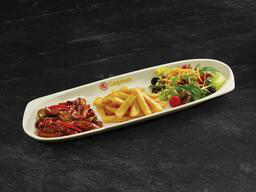

cal_test: 139.07567262649536 kcal per 100 gram	fat_test: 6.183125823736191 per 100 gram	carb_test: 13.37134838104248 per 100 gram	prot_test: 7.016287744045258 per 100 gram


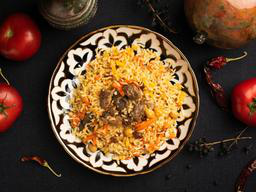

cal_test: 130.69422245025635 kcal per 100 gram	fat_test: 6.030832231044769 per 100 gram	carb_test: 8.755739033222198 per 100 gram	prot_test: 10.480039566755295 per 100 gram


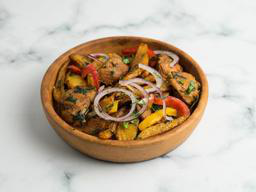

cal_test: 138.53851556777954 kcal per 100 gram	fat_test: 5.925281345844269 per 100 gram	carb_test: 9.494350105524063 per 100 gram	prot_test: 11.078181862831116 per 100 gram


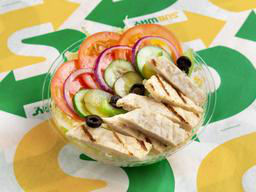

cal_test: 112.40594387054443 kcal per 100 gram	fat_test: 4.863552376627922 per 100 gram	carb_test: 7.687357813119888 per 100 gram	prot_test: 9.412974864244461 per 100 gram


In [38]:
img_paths = get_filenames("for_test")

for img_path in img_paths:
  img, cal_test, fat_test, carb_test, prot_test = test(img_path, net)
  display(img)
  print("cal_test: {} kcal per 100 gram\tfat_test: {} per 100 gram\tcarb_test: {} per 100 gram\tprot_test: {} per 100 gram".format(cal_test, fat_test, carb_test, prot_test))